# PhageHostLearn - data exploration

The goal of this notebook is to explore both the RBP sequence data and K-loci sequence data in depth in the light of their specificity towards a serotype (CLT, cfr Beamud et al, 2022). 


- **K-loci clustering and exploration**: where do they differ, how much variation is there?, how much variation between clusters? which differences lead to differences in K-type? link paper beamud?! linked RBPs for each cluster: do an MSA to see their similarity within a cluster: which protein differ? LociBase.json → pick out the relevant proteins and do pairwise alignments. How similar are equal serotypes and how different are different serotypes? similarities between old and new dataset?

- **RBP clustering and exploration**: do the RBPs pointing to one serotype cluster together? I.e. are the RBPs within a serotype more similar then the RBPs between serotypes? This is what you should indeed expect right?! Zijn er specifieke clusters die dicht bij elkaar liggen → leert het model daartussen extrapoleren → specifieke evaluatie daarvoor. Identical RBPs that map to different loci?! Are those loci the same serotype?! construct circos graphs visualizing the N- or C-terminal combinations in the different species. Visually, this answers the question of how modules are related within and accross the species (which building blocks are shared. RBPs between old and new data → do we have identicals across data?

If both mostly cluster by sero, we would expect that to be a predictive signal.

## Libraries & file paths

In [2]:
import math
#import umap
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import explore_utils as exu
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.Seq import Seq
#from chord import Chord
from tqdm.notebook import tqdm
from plots2 import CircosPlot
%matplotlib inline

In [3]:
valencia_dir = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/42_DATA/Valencia_data' # general directory
data_suffix = 'Valencia' # choose a suffix for the created data files
cdpath = '/Users/dimi/cd-hit-v4.8.1-2019-0228'
psicdpath = '/Users/dimi/cd-hit-v4.8.1-2019-0228/psi-cd-hit'
clustalpath = '/Users/dimi/GoogleDrive/PhD/3_PHAGEBASE/32_DATA/RBP_detection/clustalo'

## K-loci exploration

In [31]:
# do CD-HIT-EST clustering
file = valencia_dir+'/kaptive_results_all_loci.fasta'
output = valencia_dir+'/loci_exploration/loci_clusters'+data_suffix+'80%'
out, err = exu.cdhit_est_python(cdpath, file, output, c=0.80, n=5)

In [38]:
# load results and process
output = valencia_dir+'/loci_exploration/loci_clusters'+data_suffix+'80%'
clusters = open(output+'.clstr')
cluster_iter = 0
cluster_dict = {} # cluster number: [accessions]
percentages = []
for line in clusters.readlines():
    # new cluster
    if line[0] == '>':
        name = line[1:-1]
        cluster_dict[name] = []
        cluster_iter += 1   
    # in a cluster
    else:
        acc = line.split('>')[1].split('...')[0] # get accession
        cluster_dict[name].append(acc)
        try:
            percentage = line.split('at +/')[1].split('%')[0] # get percentage identity in cluster
            percentages.append(percentage)
        except:
            pass

In [40]:
# process clusters to assess diversity
#cluster_dict = {key: cluster_dict[key] for key in cluster_dict.keys() if len(cluster_dict[key]) > 1}
cluster_seros = {}
percentages = [float(i) for i in percentages]

file = valencia_dir+'/kaptive_results_all_loci.fasta'
names = [record.id for record in SeqIO.parse(file, 'fasta')]
seros = pd.read_csv(valencia_dir+'/serotypesValencia.csv')
seros = list(seros['sero'])

for key in cluster_dict.keys():
    cluster_seros[key] = [seros[names.index(value)] for value in cluster_dict[key]]
cluster_seros

{'Cluster 0': ['K50'],
 'Cluster 1': ['K4'],
 'Cluster 2': ['K65'],
 'Cluster 3': ['K5'],
 'Cluster 4': ['K14', 'K14', 'K14', 'K14', 'K14'],
 'Cluster 5': ['K64', 'K64', 'K64'],
 'Cluster 6': ['K7', 'K7'],
 'Cluster 7': ['K80'],
 'Cluster 8': ['K64'],
 'Cluster 9': ['K41'],
 'Cluster 10': ['unknown (KL128)', 'unknown (KL128)'],
 'Cluster 11': ['K6'],
 'Cluster 12': ['K33'],
 'Cluster 13': ['unknown (KL108)'],
 'Cluster 14': ['K58'],
 'Cluster 15': ['K39'],
 'Cluster 16': ['K12', 'K12'],
 'Cluster 17': ['K66'],
 'Cluster 18': ['unknown (KL105)', 'unknown (KL105)', 'unknown (KL105)'],
 'Cluster 19': ['K16', 'K16', 'K16', 'K16', 'K16'],
 'Cluster 20': ['K3', 'K3', 'K3'],
 'Cluster 21': ['unknown (KL158)'],
 'Cluster 22': ['K60'],
 'Cluster 23': ['K35'],
 'Cluster 24': ['K31', 'K31', 'K31'],
 'Cluster 25': ['K35', 'K35'],
 'Cluster 26': ['K42'],
 'Cluster 27': ['K13', 'K13', 'K13', 'K13', 'K13', 'K13', 'K13', 'K13'],
 'Cluster 28': ['K10', 'K10'],
 'Cluster 29': ['K62'],
 'Cluster 30': ['u

In [41]:
# select key if not all items in list are identical -> go to cluster_dict and check the genome names 
# -> write those to files per cluster to process in mauve
mixed_clusters = {key: cluster_dict[key] for key in cluster_seros.keys() if len(list(set(cluster_seros[key]))) > 1}
all_loci_file = valencia_dir+'/kaptive_results_all_loci.fasta'

for key in mixed_clusters.keys():
    fasta_file = open(valencia_dir+'/loci_exploration/loci_'+key+'.fasta', 'w')
    sequences = [str(record.seq) for record in SeqIO.parse(all_loci_file, 'fasta') if record.id in mixed_clusters[key]]
    for i, sequence in enumerate(sequences):
        fasta_file.write('>'+mixed_clusters[key][i]+'\n'+sequence+'\n')
    fasta_file.close()

In [24]:
mixed_clusters

{'Cluster 37': ['HGV2_430', '806', 'KP_HGUA02_099'],
 'Cluster 61': ['Kpcas091', '242KP-HG'],
 'Cluster 69': ['HGV2_429', 'KP_HGUA03_108'],
 'Cluster 88': ['ERS715468', 'ERS799798', '255KP-HG', '1210']}

In [ ]:
# go to LociBase.json and check their proteins for pairwise alignments
# ...

In [ ]:
# plot identity percentages
fig, ax = plt.subplots(figsize=(10,8))
ax.hist(percentages, bins=50)
ax.set_xlabel('identity percentage')
ax.set_ylabel('occurrence')

### Literature

From Wyres (2016), we notice that different K-loci predominantly differ in their wzc gene (same K-loci always around 99-95% id, different K-loci around 80-75% id); although this solely does not sketch the complete picture.

### Results clustering at 90%

Clustering the 196 K-loci at 90% yields 115 different clusters. By itself, this indicates that there is a somewhat good diversity among the collected strains. This is also seen in the Kaptive serotype/CLT predictions: we see many different K-types occurring (how many?). 

Of the clusters at 90% with more than one member, we see serotypes clustering together perfectly, as we would expect. Definitively if you look at the very high identity percentage within the clusters, it would be surprising to see different K-types in the same cluster. This doesn't answer the question however if all serotypes are present in those clusters, most likely not and so there are even bigger differences that still make it to the same K-type (but how much of a difference?).

For specificity predictions, we would now be interested in how much the different clusters are different from one another, and where? (so we basically ask: how do K-types differ from one another?)

**Similarities between old and new dataset?** We see that both cluster together just as you would expect by K-type, we also even see some exactly identical loci at the DNA level: (ERS659578, ERS659577), (1446, CU276, CU293), (KP_HGE01_029, HGV2C_11), (Kpcas042, HAV1_14, 102KP-HG), (HGV2C_08, NTUH), (159KP-HG, 268KP-HG), (HCV1_33, KP_HGUA02_092), (48KP-HG, 34KP-HG), (CU443, HGV2_418, CU448, CU451). Follow-ups: do these have identical infection patterns? If not, are they different at protein level?

**How much variation is there?** So far, we see both equal K-types being very similar as well as more than 10% different, and different K-types all more than 10% different.

**which differences lead to differences in K-type?** So far, we're seeing that only differences below 90% similarity potentially lead to differences in K-type! At least were seeing that small differences don't lead to differences in K-type, which is good in terms of our feature engineering approach. If not, maybe subtle diffs in one or a few proteins could be important, and we would have to tailor our features to that.

**How similar are equal serotypes and how different are different serotypes?** What we are seeing do far is that equal serotypes are +90% identical, often +95%, and different K-loci are less then 90% identical. From the percentages histogram, we can see that all equal K-loci cluster (we only had equal ones) are more than 90% identical, and actually most of them are +99% identical!

**how much variation between clusters?** Depends on what threshold you cluster of course!

### Results clustering at 80%

Let's redo the clustering but now at 80% to see if the K-types in unique clusters now get added to the clusters that were already establshed at 90%.

At first sight, at 80% we do see a few more loci clustering together, but not a lot more either. Let's process the results and see how it relates to K-type. We see that of the 104 clusters, now 4 of them contain two different K-types:

'Cluster 37': ['HGV2_430', '806', 'KP_HGUA02_099'], 'Cluster 61': ['unknown (KL107)', 'K19'] = ['Kpcas091', '242KP-HG'], 'Cluster 69': ['unknown (KL107)', 'unknown (KL136)'] = ['HGV2_429', 'KP_HGUA03_108'], 'Cluster 88': ['K22', 'K37', 'K37', 'K22'] = ['ERS715468', 'ERS799798', '255KP-HG', '1210']

**where do they differ, how much variation is there?** Cluster 88 was expected from literature, Wyres also pointing this out that K22 and K37 differ only due to point mutation causing an early stop codon. Mauve also points this out: both K37 K-type sequences are a little shorter. Both K22 sequences contain a extra piece at the end of the locus. Mauve points out that the different K-types in Cluster 37 might be an artifact. More specifically, '806' loci is not complete, and thus points to KL107 but this might be false as it is an incomplete locus. Cluster 61 seems to be quite diverse, both entries miss a significant portion, more specifically 242KP-HG possesses a ~8000bp 5' part and a terminal part at 24000 bp that are not present in Kpcas091, while Kpcas091 possesses a small extra piece around 14000-15000 bp. For Cluster 69, we see the same observation as Cluster 61, but in a more extreme way, two large pieces of DNA are not shares between both entries. Might indicate incomplete locus. Strange though that CD-hit than clusters these together at 80%, while Mauve indicates the difference is actually much larger. Probably aligns / computes identity to the shortest sequence?

**which differences lead to differences in K-type? Which proteins differ there?** As it seems from Mauve, corresponding proteins differ only a little, but the big differences are actually added/missing pieces of DNA, so extra proteins that lead to another K-type specificity.

Overall, these results confirm our hypothesis that loci's cluster by K-type (accross the two datasets) and show that different K-types mostly differ significantly (not subtly), so we would assume that a global feature representation taking into account all of the proteins would be a good representation.

### Results in the context of papers Wyres, Beamud, Lam, Wick

What literature describes is that mostly the start and the end of loci regions is conserved, and the core region is the capsule-sugar-specific region that differs. Our results indicate that these differences must be larger than 10% identity, as they would otherwise cluster together (except for K22-K37 as described earlier).

As Lam et al (2021) say: "Comparison of the K loci of the 77 original capsule serotype reference strains showed that all but two could be distinguished by a unique combination of genes in the centre of the locus". This is further confirmed by our results. -> no subtle differences lead to different K-type.

### Linked RBPs to cluster 88

**linked RBPs for each cluster: do an MSA to see their similarity within a cluster.** One final thing that would be interesting to check out is how the RBPs linked to cluster 88 are similar or different. To do so, we need to check out the phages that are linked to these bacterial entries and select their RBPs for pairwise alignment.

In [45]:
# look at linked RBPs in cluster 88 to see how they differ
RBPbase = pd.read_csv(valencia_dir+'/RBPbase'+data_suffix+'.csv')
interactions = pd.read_csv(valencia_dir+'/phage_host_interactionsValencia.csv', index_col=0)

# get all the linked phages
phage_names = []
for item in mixed_clusters['Cluster 88']:
    phage_names = phage_names + list(interactions.loc[item][interactions.loc[item]== 1].index)
    
# get all their RBPs and write to fasta
temp_fasta = open(valencia_dir+'/loci_exploration/RBP_sequences_cluster88.fasta', 'w')
for i, phage_id in enumerate(RBPbase['phage_ID']):
    if phage_id in phage_names:
        temp_fasta.write('>'+RBPbase['protein_ID'][i]+'\n'+RBPbase['protein_sequence'][i]+'\n')
temp_fasta.close()

In [ ]:
# cluster the linked RBPs
input_fasta = valencia_dir+'/loci_exploration/RBP_sequences_cluster88.fasta'
output = valencia_dir+'/loci_exploration/RBP_clusters_loci_Cluster88'
out, err = exu.cdhit_python(cdpath, input_fasta, output, c=0.50, n=3)

In [3]:
# clustal omega
input_fasta = valencia_dir+'/loci_exploration/RBP_sequences_cluster88.fasta'
output_file = valencia_dir+'/loci_exploration/RBPs_cluster88_alignment.fa'
out, err = exu.clustalo_python(clustalpath, input_fasta, output_file, out_format='fa')

### Results linked RBPs

From what we can see in cluster 88: ['K22', 'K37', 'K37', 'K22'] = ['ERS715468', 'ERS799798', '255KP-HG', '1210'], we have two samples from the old dataset and two of the new dataset.
Although we don't have the genomes for the corresponding phages in the old part of the dataset, looking at the interaction matrix we see exactly the same pattern as in the new dataset. All of these phages have 2 distinct RBPs and target two different K-types. Most logically, each of the RBPs targets one of the K-types, but honestly we cannot be sure about that. Perhaps one of both is broad enough to infect both K-types and the second RBP is non-functional...

If the first hypothesis is correct, we see that diverse RBPs (< 50% identical, otherwise all in the same cluster), target similar but different K-types -> see likes dissolve likes concept in 2D

There is one other phage in the clustering: M5b, this one ALSO targets both '255KP-HG' and '1210' although it has NO RBP in the 2nd cluster! Either:

1) only RBP cluster 1 is responsible for infecting both K-types (m5b has an RBP in it)

2) RBP cluster 1 infects one of both, cluster 2 the other and m5b uses yet another RBP for the second K-type

In both cases, this does not seem to indicate that subtle diffs are important. One of our hypothesis is that if similar RBPs bind to different/diverse loci, than subtle differences are important. But here we might have exactly the same RBP responsible for binding to two similar loci, which is a different thing.

The MSA doesn't shed much extra light, indeed clusters 1 and 2 both have very similar RBPs in them, but it is still a mistery as to whether one of the other RBP clusters is involved in the specificity towards one of the K-types.

### Similar loci relate to similar RBPs?

We look at this unrelated to K-type, just looking at similar loci at the DNA level, and how they are linked to RBPs that might or might not also be similar.

In [19]:
# load cluster results and process
output = valencia_dir+'/loci_exploration/loci_clusters'+data_suffix+'90%'
clusters = open(output+'.clstr')
cluster_iter = 0
cluster_dict = {} # cluster number: [accessions]
percentages = []
for line in clusters.readlines():
    # new cluster
    if line[0] == '>':
        name = line[1:-1]
        cluster_dict[name] = []
        cluster_iter += 1   
    # in a cluster
    else:
        acc = line.split('>')[1].split('...')[0] # get accession
        cluster_dict[name].append(acc)
        try:
            percentage = line.split('at +/')[1].split('%')[0] # get percentage identity in cluster
            percentages.append(percentage)
        except:
            pass

In [20]:
# filter for clusters with more than 5 loci in them
cluster_dict = {key: cluster_dict[key] for key in cluster_dict.keys() if len(cluster_dict[key]) >= 5}

In [22]:
# look at linked RBPs to see how they differ
RBPbase = pd.read_csv(valencia_dir+'/RBPbase'+data_suffix+'.csv')
interactions = pd.read_csv(valencia_dir+'/phage_host_interactionsValencia.csv', index_col=0)

# get all the linked phages
for cluster in cluster_dict.keys():
    # get all the linked phages
    phage_names = [list(interactions.loc[item][interactions.loc[item] == 1].index) for item in cluster_dict[cluster]]
    phage_names = sum(phage_names, []) # merge list of lists
    
    # get all their RBPs and write to fasta
    temp_fasta = open(valencia_dir+'/loci_exploration/RBP_sequences_'+cluster.replace(' ', '')+'.fasta', 'w')
    for i, phage_id in enumerate(RBPbase['phage_ID']):
        if phage_id in phage_names:
            temp_fasta.write('>'+RBPbase['protein_ID'][i]+'\n'+RBPbase['protein_sequence'][i]+'\n')
    temp_fasta.close()

In [23]:
# cluster the linked RBPs
for cluster in cluster_dict.keys():
    input_fasta = valencia_dir+'/loci_exploration/RBP_sequences_'+cluster.replace(' ', '')+'.fasta'
    output = valencia_dir+'/loci_exploration/RBP_clusters_loci_'+cluster.replace(' ', '')
    out, err = exu.cdhit_python(cdpath, input_fasta, output, c=0.50, n=3)

### Results linked RBPs to similar loci clusters at 90%

After clustering the RBPs linked to each 90% loci cluster at 50%, we see several things:
- Cluster 21: the RBPs don't cluster together at all. Although this concerns only 3 distinct phages, none of their predicted RBPs cluster together, indicating that dissimilar RBPs can target similar loci! Given that the RBPs are well predicted.
- Cluster 30, 54: hard to say. We do see very similar RBPs clustering together, but can't say if they are effectively targeting the loci in that cluster. One possible scenario is that each small cluster of very similar RBPs targets one of the similar loci in the cluster. But even then the observation stands that overall, dissimilar RBPs can target similar loci.
- Cluster 76: two phages of the old dataset, 5 RBPs, all in different clusters. This is hard to interpret as well because for all of the loci present in this cluster that are from the new dataset, we don't have any positive linked phages. We only have these two phages of the old dataset, linked to 1 of the 5 loci in this cluster. This thus only concludes that two different phages can have diverse RBPs and still target the same locus.
- Cluster 104: similar RBPs, similar loci to some extent.
- Cluster 107: again, dissimilar RBPs target similar loci -> this actually can also indicate that the phage doesn't target the loci at all, that we have diverse RBPs targeting something other than the locus!


This would be a lot easier to study specifically for the monoRBP phages, i.e. looking at phages that only have one RBP, clustering their linked loci and then repeating the analysis to see if each loci cluster contains similar RBPs.

### Other general exploration

In [ ]:
# serotype occurrences histogram
import seaborn as sns
seros = pd.read_csv(valencia_dir+'/serotypes'+data_suffix+'.csv')
seros_dict = {key: list(seros['sero']).count(key) for key in unique_seros}
fig, ax = plt.subplots(figsize=(10, 14))
ax = sns.countplot(y="sero", data=seros, order = seros['sero'].value_counts().index)
fig.savefig('/Users/Dimi/Desktop/serotype_occurrences.png', dpi=400)

In [ ]:
# number of proteins per locus
protein_number = [len(Locibase[key]) for key in Locibase.keys()]
fig, ax = plt.subplots(figsize=(10,8))
ax.hist(protein_number)
ax.set_xlabel('Number of proteins')
ax.set_ylabel('Number of occurrences')
fig.savefig('/Users/Dimi/Desktop/number_of_proteins_per_loci.png', dpi=400)

## RBP clustering exploration

In [4]:
# load appropriate files
RBPbase = pd.read_csv(valencia_dir+'/RBPbase'+data_suffix+'.csv')
interactions = pd.read_csv(valencia_dir+'/phage_host_interactionsValencia.csv', index_col=0)

file = valencia_dir+'/kaptive_results_all_loci.fasta'
names = [record.id for record in SeqIO.parse(file, 'fasta')]
seros = pd.read_csv(valencia_dir+'/serotypesValencia.csv')
seros = list(seros['sero'])

# add seros column to RBPbase
RBP_seros = {'linked_seros': []}
for i, phage_id in enumerate(RBPbase['phage_ID']):
    linked_hosts = list(interactions[phage_id][interactions[phage_id]==1].index)
    linked_seros = []
    for host in linked_hosts:
        try:
            linked_seros.append(seros[names.index(host)])
        except:
            pass
    RBP_seros['linked_seros'].append(list(set(linked_seros)))
RBPbase_withseros = pd.concat([RBPbase, pd.DataFrame(RBP_seros)], axis=1)

In [46]:
# write RBPs to fasta file
input_file = valencia_dir+'/rbp_exploration/RBPbase'+data_suffix+'.fasta'
temp_fasta = open(input_file, 'w')
for i, protein_sequence in enumerate(RBPbase_withseros['protein_sequence']):
    name = RBPbase_withseros['protein_ID'][i]
    linked_seros = ''.join(RBPbase_withseros['linked_seros'][i])
    temp_fasta.write('>'+name+'-'+linked_seros+'\n'+protein_sequence+'\n')
temp_fasta.close()
    
# do cd-hit clustering
# n=5 for c=0.7-1.0; n=3 for c=0.5-0.6
output_file = valencia_dir+'/rbp_exploration/RBPbase_clusters_50%'
out, err = exu.cdhit_python(cdpath, input_file, output_file, c=0.50, n=3)

### Results RBP clustering at 50%

At 50%, we see 118 clusters formed by the 266 RBPs. At 50%, we still see 74 RBPs that don't cluster together with anything else, which indicates a lot of diversity in our RBPs (although not all of them may be true positives of course!).

Looking at the clusters, we both see diverse clusters (e.g. clustering ar around 50-55%) as well as highly identical clusters (+90%). The difficulty in interpreting these clusters is that phages may have multiple RBPs and targeting multiple K-types, thus we don't know which RBP leads to which K-type. One thing we do already see is that some highly similar RBPs target different clusters (e.g. cluster 40), indicating that subtle differences are important for diverse specificity OR that these highly similar RBPs actually target something that is K-type independent. -> although we would only expect this in a minority of the cases for phages that are broad (if it is K-type independent, we expect this phage to infect broadly). and we don't see that in the sero labeling we have added, so are first hypothesis seems more likely to be true.

We also see the clusters with A1x phages targeting K22 and K37 that we have encountered in the loci clustering. Here we also see two clusters that seem highly identical and targeting two or multiple K-types.

Clusters 63, 69: these seems to be clusters that are K-type independent.

**do the RBPs pointing to one K-type cluster together? I.e. are the RBPs within a K-type more similar then the RBPs between K-types?** Overall, we see that both subtle diffs and larger (20-30%) diffs can lead to differences in K-type. So, no overall RBPs don't *solely* cluster together on K-type (they do but even across different ones)

**Identical RBPs that map to different loci?! Are those loci the same serotype?!** We also only see two identical RBPs, in cluster 113: K18PH07C1_gp91 and K45PH128C2_gp137 targeting different K-types! This might be a false correlation, i.e. there might be other RBPs involved in those phages that lead to difference K-type specificity.

**RBPs between old and new data → do we have identicals across data?** We don't see any identicals across our two datasets.

### ClustalOmega MSAs to see subtle differences

In [120]:
# process clusters into dictionaries
clusters = open(valencia_dir+'/rbp_exploration/RBPbase_clusters_50%.clstr')
cluster_dict = {} # cluster number: [accessions]
percentages_dict = {} # cluster number: [percentages]
for line in clusters.readlines():
    # new cluster
    if line[0] == '>':
        name = line[1:-1]
        cluster_dict[name] = []
        percentages_dict[name] = []
    # in a cluster
    else:
        protein_name = line.split('>')[1].split('-')[0] # get name
        cluster_dict[name].append(protein_name)
        try:
            percentage = line.split('at ')[1].split('%')[0] # get percentage identity in cluster
            percentages_dict[name].append(float(percentage))
        except:
            pass

In [140]:
# write fasta files for MSAs
fasta_names = []
for cluster in cluster_dict.keys():
    if len(cluster_dict[cluster]) >= 10:
        fasta_name = valencia_dir+'/rbp_exploration/RBPs_'+cluster.replace(' ', '')+'.fasta'
        fasta_names.append(fasta_name)
        temp_fasta = open(fasta_name, 'w')
        for pid in cluster_dict[cluster]:
            sequence = list(RBPbase['protein_sequence'][RBPbase['protein_ID'] == pid])[0]
            temp_fasta.write('>'+pid+'\n'+sequence+'\n')
        temp_fasta.close()
        
# clustal omega
for name in fasta_names:
    output_file = name.split('.fasta')[0]+'_alignment.fa'
    out, err = exu.clustalo_python(clustalpath, name, output_file, out_format='fa')

In [142]:
RBPbase['phage_ID'][RBPbase['phage_ID'] == 'K16PH164C3']

215    K16PH164C3
216    K16PH164C3
Name: phage_ID, dtype: object

**how do diffs lead to different specificity?**

Cluster 1 clustered at 51-61% identity and looking at the alignments in Jalview, we see that the N-termini are very conserved, while the C-termini (last ~300 AAs are much less conserved). A classical example in the phage world I would say.

Cluster 30 clustered at 60-98% although this may give a wrong perception as the longest sequence was the representative here. Actually looking at the alignment unveils that most sequences are quite conserved overall, again the C-terminus being a little less conserved but here you might already say that subtle differences are probably important to take up into the feature representation.

Cluster 40 clustered at 64-98%, mostly 90+% identical. Here, subtle diffs really make up the bulk of what makes every sequence in the cluster unique! Together with the linked seros, which are quite diverse, this really indicates that subtle differences can lead to a difference in specificity (given that we have correctly identified these sequences as RBPs of course!!). This supports the hypothesis that a feature representation tailored to these subtle differences might be important in trying to predict host specificity.

Cluster 42 mainly clustered at around 84% and this is also what you see in the alignment. A small number of unique columns of AAs in the alignment show a lot less conservation, and you naturally wonder where these AAs specifically would be located in the 3D structure...

**how many multiRBP systems target multiple serotypes?** From what Beamud (2022) saw, phages tend to have more depolymerases than they target different K-types, indicating either unused depos or missing K-types in the dataset, OR multiple depo's needed for one and the same K-type?

To see this, we look at the number of RBPs a phage has and the number of unique sero's it targets and plot them together.

In [103]:
RBP_sero_counts = []
for phage in list(set(RBPbase_withseros['phage_ID'])):
    RBP_count = list(RBPbase_withseros['phage_ID']).count(phage)
    unique_seros = list(set(sum(RBPbase_withseros['linked_seros'][RBPbase_withseros['phage_ID'] == phage], [])))
    sero_count = len(unique_seros)
    RBP_sero_counts.append((RBP_count, sero_count))
occurrence = [RBP_sero_counts.count(x) for x in RBP_sero_counts]

Text(0, 0.5, 'number of unique K-types')

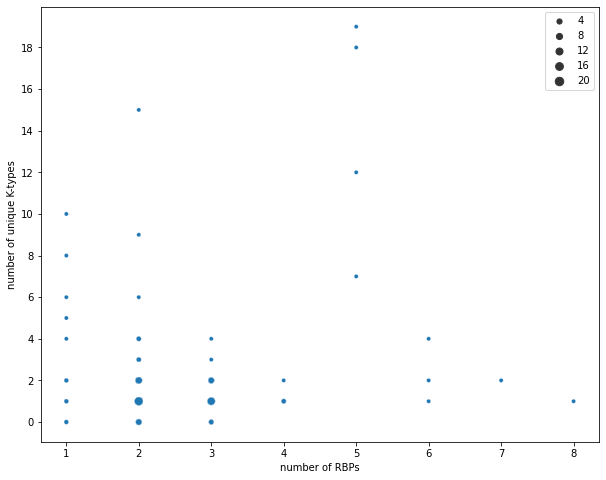

In [106]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(x=[i for (i,j) in RBP_sero_counts], y=[j for (i,j) in RBP_sero_counts], size=occurrence)
ax.set_yticks(list(range(0,20,2)))
ax.set_xlabel('number of RBPs')
ax.set_ylabel('number of unique K-types')

As we can see, a large chunck sits below the bissectrice, supporting Beamud's finding that there are more RBPs than unique serotypes that are infected. However, we also see exceptions to this in both directions: phages with multiple RBPs targeting (very) few K-types and phages with few RBPs targeting many K-types. The zero on the y-axis indicates that no K-type was found due to unavailable bacterial genome, so these are points that should not be interpreted.

Outliers can be a problem. Its not directly the K-type that we predict, but we do incorporate the loci proteins in our features, so…

## RBP puzzle: elucidating RBP-K links with bioinformatics

In this section, we look at the links between RBPs and K-types, starting from the RBPs that have a 1:1 relationship with a K-type, i.e. phages with only 1 RBP targeting 1 K-type. Then, we cluster those sequences to generalize to phages with 2 RBPs infecting 2 K-types, and so on.

In [5]:
def single_pwalign_julia(project_dir, sequence1, sequence2, align_type):
    """
    Returns the % identity score between two sequences.
    
    Remark: first run the alias command once in therminal to enable julia from command line!
    """
    #alias_command = 'sudo ln -fs julia="/Applications/Julia-1.6.app/Contents/Resources/julia/bin/julia" /usr/local/bin/julia'
    cd_command = 'cd ' + project_dir
    pw_command = 'julia single_pwalign.jl ' + sequence1 + ' ' + sequence2 + ' ' + align_type
    command = cd_command + '; ' + pw_command

    ssprocess = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    ssout, sserr = ssprocess.communicate()
    
    return float(ssout)

In [ ]:
project_dir = '/Users/dimi/Documents/GitHub/PhageHostLearning/learning'
results_dir = '/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/43_RESULTS/RBP_exploration'

### Starting from 1:1 phages

In [11]:
# get 1:1 RBPs
index11 = []
for i, phage in enumerate(RBPbase_withseros['phage_ID']):
    linked_ser = RBPbase_withseros['linked_seros'][i]
    if (list(RBPbase_withseros['phage_ID']).count(phage) == 1) and (len(linked_ser) == 1): # one RBP and one sero
        index11.append(i)
RBPs11 = RBPbase_withseros.iloc[index11]

In [24]:
# get 2:1 RBPs
index21 = []
for i, phage in enumerate(RBPbase_withseros['phage_ID']):
    linked_ser = RBPbase_withseros['linked_seros'][i]
    if (list(RBPbase_withseros['phage_ID']).count(phage) == 2) and (len(linked_ser) == 1): # one RBP and one sero
        index21.append(i)
RBPs21 = RBPbase_withseros.iloc[index21]

In [62]:
verified21 = []
scores = []
bar = tqdm(total = len(RBPs11['protein_sequence'])*len(RBPs21['protein_sequence']))
for i, protein11 in enumerate(RBPs11['protein_sequence']):
    for j, protein21 in enumerate(RBPs21['protein_sequence']):
        score = single_pwalign_julia(project_dir, protein11, protein21, 'protein')
        scores.append(score)
        if (score > 0.9) and (list(RBPs11['linked_seros'])[i][0] == list(RBPs21['linked_seros'])[j][0]):
            verified21.append(j)
        elif (score > 0.9) and (list(RBPs11['linked_seros'])[i][0] != list(RBPs21['linked_seros'])[j][0]):
            print(RBPs11['linked_seros'][i], RBPs21['linked_seros'][j])
        bar.update(1)
bar.close()
RBPs21verified = RBPs21.iloc[verified21]

  0%|          | 0/80 [00:00<?, ?it/s]

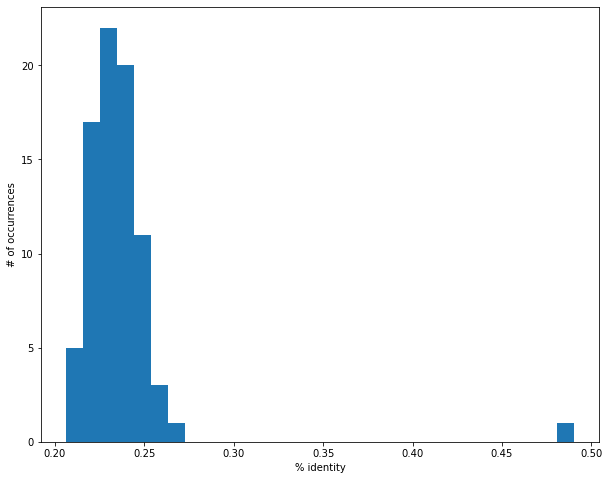

In [61]:
fig, ax = plt.subplots(figsize=(10,8))
ax.hist(scores, bins=30)
ax.set_xlabel('% identity')
ax.set_ylabel('# of occurrences')
fig.savefig(results_dir+'/RBPs11_RBPs21_identity_percentage.png', dpi=400)

In the 2:1 phages, we don't find any RBPs that are similar enough to the ones we found in the 1:1 phages. Therefore, we cannot make any conclusions about which of the 2 RBPs targets the 1 sero in the 2:1 phages...

In [25]:
# get 2:2 RBPs
index22 = []
for i, phage in enumerate(RBPbase_withseros['phage_ID']):
    linked_ser = RBPbase_withseros['linked_seros'][i]
    if (list(RBPbase_withseros['phage_ID']).count(phage) == 2) and (len(linked_ser) == 2): # one RBP and one sero
        index22.append(i)
RBPs22 = RBPbase_withseros.iloc[index22]

In [68]:
verified22 = []
scores = []
bar = tqdm(total = len(RBPs11['protein_sequence'])*len(RBPs22['protein_sequence']))
for i, protein11 in enumerate(RBPs11['protein_sequence']):
    for j, protein22 in enumerate(RBPs22['protein_sequence']):
        score = single_pwalign_julia(project_dir, protein11, protein22, 'protein')
        scores.append(score)
        if (score > 0.9) and (list(RBPs11['linked_seros'])[i][0] in list(RBPs22['linked_seros'])[j]):
            verified22.append(j)
        elif (score > 0.9) and (list(RBPs11['linked_seros'])[i][0] not in list(RBPs22['linked_seros'])[j]):
            print(RBPs11['linked_seros'][i], RBPs22['linked_seros'][j])
        bar.update(1)
bar.close()
RBPs22verified = RBPs22.iloc[verified22]

  0%|          | 0/44 [00:00<?, ?it/s]

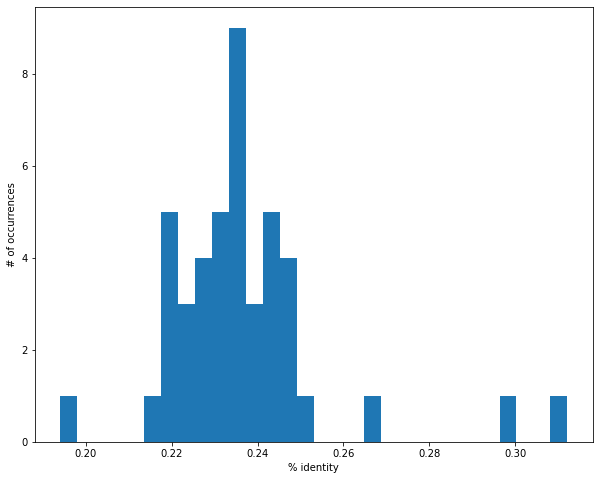

In [70]:
fig, ax = plt.subplots(figsize=(10,8))
ax.hist(scores, bins=30)
ax.set_xlabel('% identity')
ax.set_ylabel('# of occurrences')
fig.savefig(results_dir+'/RBPs11_RBPs22_identity_percentage.png', dpi=400)

Again, no luck finding similar RBPs that we could elucidate the actual K-type of... Let's do three more things: (1) check the 3:1 phages, (2) check the 3:2 phages (same scenario as the 2:2 phages but now we won't able to say something about the other linked K-type as we have 2 RBPs left...) and (3) pwalign all 2:2 RBPs: if we find two that are similar, and they share a K-type, it's probably that one; definitely if the other two RBPs are not similar. Then we can immediately also say something about those other specificities.

In [8]:
# get 3:1 RBPs
index31 = []
for i, phage in enumerate(RBPbase_withseros['phage_ID']):
    linked_ser = RBPbase_withseros['linked_seros'][i]
    if (list(RBPbase_withseros['phage_ID']).count(phage) == 3) and (len(linked_ser) == 1): # 3 RBPs and one sero
        index31.append(i)
RBPs31 = RBPbase_withseros.iloc[index31]

In [12]:
verified31 = []
scores = []
bar = tqdm(total = len(RBPs11['protein_sequence'])*len(RBPs31['protein_sequence']))
for i, protein11 in enumerate(RBPs11['protein_sequence']):
    for j, protein31 in enumerate(RBPs31['protein_sequence']):
        score = single_pwalign_julia(project_dir, protein11, protein31, 'protein')
        scores.append(score)
        if (score > 0.9) and (list(RBPs11['linked_seros'])[i][0] == list(RBPs31['linked_seros'])[j][0]):
            verified31.append(j)
        elif (score > 0.9) and (list(RBPs11['linked_seros'])[i][0] != list(RBPs31['linked_seros'])[j][0]):
            print(RBPs11['linked_seros'][i], RBPs31['linked_seros'][j])
        bar.update(1)
bar.close()
RBPs31verified = RBPs31.iloc[verified31]

  0%|          | 0/96 [00:00<?, ?it/s]

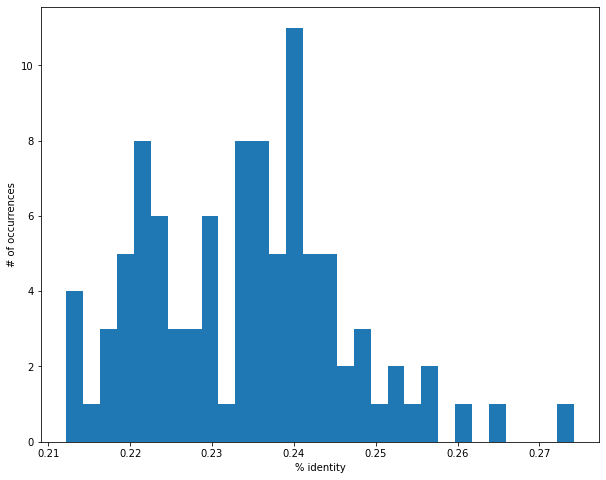

In [14]:
fig, ax = plt.subplots(figsize=(10,8))
ax.hist(scores, bins=30)
ax.set_xlabel('% identity')
ax.set_ylabel('# of occurrences')
fig.savefig(results_dir+'/RBPs11_RBPs31_identity_percentage.png', dpi=400)

In [17]:
# get 3:2 RBPs
index32 = []
for i, phage in enumerate(RBPbase_withseros['phage_ID']):
    linked_ser = RBPbase_withseros['linked_seros'][i]
    if (list(RBPbase_withseros['phage_ID']).count(phage) == 3) and (len(linked_ser) == 2): # 3 RBPs and two seros
        index32.append(i)
RBPs32 = RBPbase_withseros.iloc[index32]

In [19]:
verified32 = []
scores = []
bar = tqdm(total = len(RBPs11['protein_sequence'])*len(RBPs32['protein_sequence']))
for i, protein11 in enumerate(RBPs11['protein_sequence']):
    for j, protein32 in enumerate(RBPs32['protein_sequence']):
        score = single_pwalign_julia(project_dir, protein11, protein32, 'protein')
        scores.append(score)
        if (score > 0.9) and (list(RBPs11['linked_seros'])[i][0] == list(RBPs32['linked_seros'])[j][0]):
            verified31.append(j)
        elif (score > 0.9) and (list(RBPs11['linked_seros'])[i][0] != list(RBPs32['linked_seros'])[j][0]):
            print(RBPs11['linked_seros'][i], RBPs32['linked_seros'][j])
        bar.update(1)
bar.close()
RBPs32verified = RBPs32.iloc[verified32]

  0%|          | 0/48 [00:00<?, ?it/s]

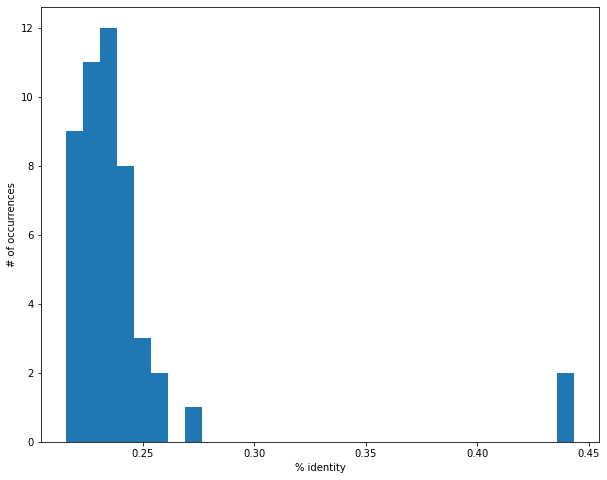

In [22]:
fig, ax = plt.subplots(figsize=(10,8))
ax.hist(scores, bins=30)
ax.set_xlabel('% identity')
ax.set_ylabel('# of occurrences')
fig.savefig(results_dir+'/RBPs11_RBPs32_identity_percentage.png', dpi=400)

### Starting from 2:1 phages

Now we'll compare the 2:1 RBPs with the 2:2, 3:1 and 3:2 RBPs. If there are similar RBPs and the K-type of 1 is among the K-types of 2 then we have a match if (both) other RBPs DON'T match (else it could be those, so can't be sure).

In [27]:
# 2:1 to 2:2
verified22 = []
scores = []
bar = tqdm(total = len(RBPs21['protein_sequence'])*len(RBPs22['protein_sequence']))
for i, protein21 in enumerate(RBPs21['protein_sequence']):
    for j, protein22 in enumerate(RBPs22['protein_sequence']):
        # align and get score
        score = single_pwalign_julia(project_dir, protein21, protein22, 'protein')
        scores.append(score)
        
        # get linked seros
        seros21 = list(RBPs21['linked_seros'])[i]
        seros22 = list(RBPs22['linked_seros'])[j]
        phagei = list(RBPs21['phage_ID'])[i]
        phagej = list(RBPs22['phage_ID'])[j]
        match_sero = list(set(seros21).intersection(seros22))
        
        if (score > 0.9) and (seros21[0] in seros22):
            print('Found probable match:', phagei, phagej, match_sero)
            verified22.append(j)
        elif (score > 0.9) and (seros21[0] not in seros22):
            print(seros21, seros22)
        bar.update(1)
bar.close()
RBPs22verified = RBPs22.iloc[verified22]

  0%|          | 0/880 [00:00<?, ?it/s]

['K14'] ['K17', 'K62']
['K25'] ['K22', 'K37']
['K25'] ['K22', 'K37']
['K25'] ['K22', 'K37']
['K25'] ['K22', 'K37']
['K25'] ['K22', 'K37']
['K25'] ['K22', 'K37']
['K25'] ['K22', 'K37']
['K20'] ['K22', 'K37']
['K20'] ['K22', 'K37']
['K20'] ['K22', 'K37']
['K20'] ['K22', 'K37']
['K20'] ['K22', 'K37']
['K20'] ['K22', 'K37']
['K20'] ['K22', 'K37']
['K8'] ['K17', 'K62']
['K8'] ['K3', 'K13']
['K3'] ['K17', 'K62']
Found probable match: K2PH164C2 K2alfa62 ['K3']
['K66'] ['K22', 'K37']
['K66'] ['K22', 'K37']
['K66'] ['K22', 'K37']
['K66'] ['K22', 'K37']
['K66'] ['K22', 'K37']
['K66'] ['K22', 'K37']
['K66'] ['K22', 'K37']
Found probable match: K2PH164C1 K2alfa62 ['K3']


We're seeing matches (identity > 0.9) between the 2:1 phages and the 2:2 phages that don't have a K-type in common. First guess is that this is then the other RBP that we are matching of the 2:1 phage of which only one K-type is known. But then this raises the question of why none of the K-type of the 2:2 phage is picked up, if these RBPs match! Then the other hypothesis is that we're seeing matches to similar K-types, and conclude that subtle diffs are important!

We also found one probable match that target the same K-type: K2PH164C1 K2alfa62 -> 'K3'. Let's check them out:

In [31]:
RBPs21sub = RBPs21[RBPs21['phage_ID'] == 'K2PH164C1']
RBPs22sub = RBPs22[RBPs22['phage_ID'] == 'K2alfa62']

for i, p1 in enumerate(RBPs21sub['protein_sequence']):
    for j, p2 in enumerate(RBPs22sub['protein_sequence']):
        print(list(RBPs21sub['protein_ID'])[i], list(RBPs22sub['protein_ID'])[j], 
              single_pwalign_julia(project_dir, p1, p2, 'protein'))

K2PH164C1_gp30 K2alfa62_gp51 0.9777034559643255
K2PH164C1_gp30 K2alfa62_gp53 0.21534195933456562
K2PH164C1_gp32 K2alfa62_gp51 0.22793404461687683
K2PH164C1_gp32 K2alfa62_gp53 0.8800623052959502


So, we see that essentially both RBPs match quite well with one another: K2PH164C1_gp30 and K2alfa62_gp51 are 97.7% identical, while K2PH164C1_gp32 and K2alfa62_gp53 are 88% identical. Two scenario's are likely:
1. K2PH164C1_gp30 and K2alfa62_gp51 target the shared K-type K3, while K2PH164C1_gp32 has evolved to lose infectivity against K13.
2. We can't tell for sure which infects which, as we should first assess whether K2PH164C1 also infects K13 (don't know if that was tested).

However, looking at the data, both are in the same Valencia set, so K2PH164C1 was tested against the K13 strain and came out negative!

In [34]:
# 2:1 to 3:1
verified31 = []
scores = []
bar = tqdm(total = len(RBPs21['protein_sequence'])*len(RBPs31['protein_sequence']))
for i, protein21 in enumerate(RBPs21['protein_sequence']):
    for j, protein31 in enumerate(RBPs31['protein_sequence']):
        # align and get score
        score = single_pwalign_julia(project_dir, protein21, protein31, 'protein')
        scores.append(score)
        
        # get linked seros
        seros21 = list(RBPs21['linked_seros'])[i]
        seros31 = list(RBPs31['linked_seros'])[j]
        phagei = list(RBPs21['phage_ID'])[i]
        phagej = list(RBPs31['phage_ID'])[j]
        match_sero = list(set(seros21).intersection(seros31))
        
        if (score > 0.9) and (seros21[0] == seros31[0]):
            print('Found probable match:', phagei, phagej, match_sero)
            verified31.append(j)
        elif (score > 0.9) and (seros21[0] != seros31[0]):
            print(seros21, seros31)
        bar.update(1)
bar.close()
RBPs31verified = RBPs31.iloc[verified31]

  0%|          | 0/1920 [00:00<?, ?it/s]

['K25'] ['K1']
['K25'] ['K15']
['K25'] ['unknown (KL126)']
['K25'] ['K51']
['K20'] ['K1']
['K20'] ['K15']
['K20'] ['unknown (KL126)']
['K20'] ['K51']
['K66'] ['K1']
['K66'] ['K15']
['K66'] ['unknown (KL126)']
['K66'] ['K51']
['K16'] ['K61']
['K16'] ['K58']
['K16'] ['K30']
['K16'] ['K56']
['K16'] ['K43']


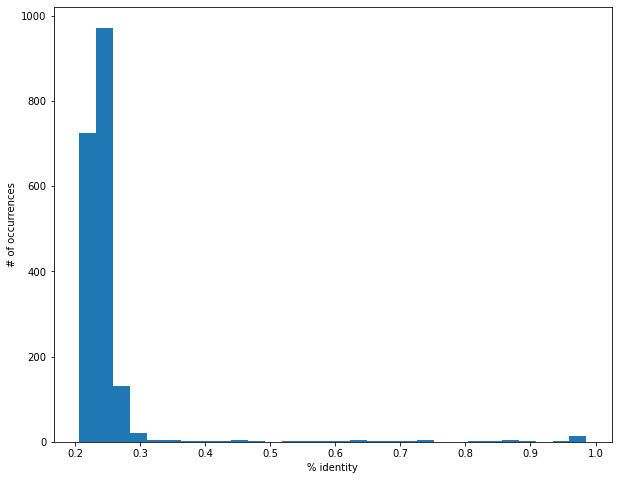

In [36]:
fig, ax = plt.subplots(figsize=(10,8))
ax.hist(scores, bins=30)
ax.set_xlabel('% identity')
ax.set_ylabel('# of occurrences')
fig.savefig(results_dir+'/RBPs21_RBPs31_identity_percentage.png', dpi=400)

In [41]:
# 2:1 to 3:2
verified32 = []
scores = []
bar = tqdm(total = len(RBPs21['protein_sequence'])*len(RBPs32['protein_sequence']))
for i, protein21 in enumerate(RBPs21['protein_sequence']):
    for j, protein32 in enumerate(RBPs32['protein_sequence']):
        # align and get score
        score = single_pwalign_julia(project_dir, protein21, protein32, 'protein')
        scores.append(score)
        
        # get linked seros
        seros21 = list(RBPs21['linked_seros'])[i]
        seros32 = list(RBPs32['linked_seros'])[j]
        phagei = list(RBPs21['phage_ID'])[i]
        phagej = list(RBPs32['phage_ID'])[j]
        match_sero = list(set(seros21).intersection(seros32))
        
        if (score > 0.9) and (seros21[0] in seros32):
            print('Found probable match:', phagei, phagej, match_sero)
            verified32.append(j)
        elif (score > 0.9) and (seros21[0] not in seros32):
            print(seros21, seros32)
        bar.update(1)
bar.close()
RBPs32verified = RBPs32.iloc[verified32]

  0%|          | 0/960 [00:00<?, ?it/s]

['K25'] ['K22', 'K37']
['K25'] ['unknown (KL126)', 'K61']
['K25'] ['K13', 'K2']
['K20'] ['K22', 'K37']
['K20'] ['unknown (KL126)', 'K61']
['K20'] ['K13', 'K2']
['K66'] ['K22', 'K37']
['K66'] ['unknown (KL126)', 'K61']
['K66'] ['K13', 'K2']
['K16'] ['K61', 'unknown (KL134)']
['K16'] ['K1', 'K2']
['K16'] ['K57', 'K11']
['K3'] ['K33', 'K55']


### Starting from 2:2 phages and aligning to themselves

In [75]:
# pw align 2:2 RBPs
verified22 = []
scores = []
bar = tqdm(total = len(RBPs22['protein_sequence'])*len(RBPs22['protein_sequence']))

for i, protein11 in enumerate(RBPs22['protein_sequence']):
    for j, protein22 in enumerate(RBPs22['protein_sequence']):
        # align and get score
        score = single_pwalign_julia(project_dir, protein11, protein22, 'protein')
        scores.append(score)
        
        # get linked seros
        seros11 = list(RBPs22['linked_seros'])[i]
        seros22 = list(RBPs22['linked_seros'])[j]
        phagei = list(RBPs22['phage_ID'])[i]
        phagej = list(RBPs22['phage_ID'])[j]
        match_sero = list(set(seros11).intersection(seros22))
        
        # check match
        if (score > 0.9) and (len(match_sero) > 0) and (i != j):
            print('Found probable match:', phagei, phagej, match_sero)
            verified22.append(i)
            verified22.append(j)
        elif (score > 0.9) and (len(match_sero) == 0):
            print('Found evidence for subtle diffs:', phagei, seros11, phagej, seros22)
        bar.update(1)
bar.close()
RBPs22verified = RBPs22.iloc[verified22]

  0%|          | 0/484 [00:00<?, ?it/s]

Found evidence for subtle diffs: K17alfa61 ['K17', 'K62'] K2alfa62 ['K13', 'K3']
Found evidence for subtle diffs: K2alfa62 ['K13', 'K3'] K17alfa61 ['K17', 'K62']
Found probable match: A1l A1n ['K22', 'K37']
Found probable match: A1l A1r ['K22', 'K37']
Found probable match: A1l A1k ['K22', 'K37']
Found probable match: A1l A1p ['K22', 'K37']
Found probable match: A1l A1o ['K22', 'K37']
Found probable match: A1l A1m ['K22', 'K37']
Found probable match: A1l A1n ['K22', 'K37']
Found probable match: A1l A1r ['K22', 'K37']
Found probable match: A1l A1k ['K22', 'K37']
Found probable match: A1l A1p ['K22', 'K37']
Found probable match: A1l A1o ['K22', 'K37']
Found probable match: A1l A1m ['K22', 'K37']
Found probable match: A1n A1l ['K22', 'K37']
Found probable match: A1n A1r ['K22', 'K37']
Found probable match: A1n A1k ['K22', 'K37']
Found probable match: A1n A1p ['K22', 'K37']
Found probable match: A1n A1o ['K22', 'K37']
Found probable match: A1n A1m ['K22', 'K37']
Found probable match: A1n A1

### Starting from 3:3 phages to identify subtle diffs

Further evidence for subtle diffs: we could extend this to 3:3 etc, if RBPs are very similar but all of the linked K-types are disjoint, then that is evidence for the fact that subte diffs matter. However, it could of course be that these RBPs target another same K-type that is not in the dataset. BUT, if we have 3 RBPs and 3 K-types, then chances of this are quite low we could say, because then we assume that each of the RBPs target 1 K-type, and thus the error will only be in cases where we (1) have a false positive RBP AND (2) the K-type is not in the dataset.

In [6]:
# get 3:3 RBPs
index33 = []
for i, phage in enumerate(RBPbase_withseros['phage_ID']):
    linked_ser = RBPbase_withseros['linked_seros'][i]
    if (list(RBPbase_withseros['phage_ID']).count(phage) == 3) and (len(linked_ser) == 3): # one RBP and one sero
        index33.append(i)
RBPs33 = RBPbase_withseros.iloc[index33]

In [7]:
RBPs33

,phage_ID,protein_ID,protein_sequence,dna_sequence,xgb_score,linked_seros
166,K74PH129C2,K74PH129C2_gp5,MALVSQSIKNLKGGISQQPEILRYPEQGSLQVNGWSSETEGLQKRP...,ATGGCTCTCGTATCACAATCAATCAAGAACCTCAAGGGAGGCATTA...,0.946969,"[K74, K80, K68]"
167,K74PH129C2,K74PH129C2_gp10,MDQEIKTVIQYPTGSTEFDIPFDYLSRKFVRVSLVANDNRRLLSNI...,ATGGACCAAGAAATTAAAACAGTCATCCAGTACCCCACAGGGTCCA...,0.985026,"[K74, K80, K68]"
168,K74PH129C2,K74PH129C2_gp11,MLNNLNQPKGSTIGVLKDGRTIQEAFDQLDPVVSLSSTVSLATAVA...,ATGTTAAACAATCTGAATCAGCCGAAAGGCTCAACCATTGGTGTGC...,0.999348,"[K74, K80, K68]"


This doesn't yield any new evidence as well, as we only find one phage that infects 3 K-types with 3 RBPs...

In [ ]:
# histogram RBP occurrence
RBPbase = pd.read_csv(valencia_dir+'/RBPbase'+data_suffix+'.csv')
unique_phage_ids = list(set(RBPbase['phage_ID']))
counts = pd.DataFrame({'count': [list(RBPbase['phage_ID']).count(unique_id) for unique_id in unique_phage_ids]})

import seaborn as sns
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.countplot(x="count", data=counts)
ax.set_xlabel('number of RBPs')
ax.set_ylabel('number of occurrences')
fig.savefig('/Users/dimi/GoogleDrive/PhD/4_PHAGEHOST_LEARNING/43_RESULTS/RBP_occurences_per_phage.png', dpi=400)

### Putting the pieces together

Overall, looking a the diversity of both the loci and RBPs, we see that the loci mostly cluster based on K-type, which is of course what we would expect, and that at the loci side, mostly big diffs occur instead of subtle diffs. 

At the RBP side however, we see

- [x] Similar RBPs targeting the same K-type / similar loci (cfr loci cluster 88, and others) to some extent, but actually not always either!
- [x] Similar RBPs targeting different K-types / dissimilar loci (looking at the various RBP clusters) -> indicating that subtle changes can change specificity (something we also see in other bacterium-phage systems -> see literature!)
- [x] Dissimilar RBPs targeting different K-types / dissimilar loci
- [x] Dissimilar RBPs targeting similar loci (clusters 21, 30, 76, ... see above)

### 2 - General overview of the data

##### Translate proteins and add to dataframe (do only once)

##### Overview table

In [5]:
species = ['enterococcus_faecium', 'staphylococcus_aureus', 'klebsiella_pneumoniae', 'acinetobacter_baumannii', 
          'pseudomonas_aeruginosa', 'enterobacter_cloacae', 'enterobacter_aerogenes']
number = []; shortest = []; longest = []; average = []; minperc = []; maxperc = []

for sp in species:
    sequences = RBPs.protein_seq[RBPs.host == sp]
    protein_lengths = [len(seq) for seq in sequences]
    shortest.append(min(protein_lengths))
    longest.append(max(protein_lengths))
    average.append(round(np.mean(protein_lengths), 2))
    number.append(sum(RBPs.host == sp))
    
    indices = RBPs.host == sp
    #RBPsub = RBPalign[indices, :][:,indices]
    #minperc.append(round(np.min(RBPsub), 3))
    minperc.append(round(np.min(RBPalign), 3))
    maxperc.append(round(np.max(RBPalign), 3))
    #maxperc.append(round(np.max(RBPsub), 3))

RBPdf = pd.DataFrame({'number_of_hits':number, 'shortest_length':shortest, 'longest_length':longest, 
                       'average_length':average, 'minimum_%id':minperc, 'maximum_%id':maxperc})
RBPdf.index = species
RBPdf

,number_of_hits,shortest_length,longest_length,average_length,minimum_%id,maximum_%id
enterococcus_faecium,393,34,965,596.29,0.13,1.0
staphylococcus_aureus,1514,42,1086,518.19,0.13,1.0
klebsiella_pneumoniae,1663,29,4356,800.42,0.13,1.0
acinetobacter_baumannii,74,43,1099,529.00,0.13,1.0
pseudomonas_aeruginosa,396,53,1257,693.38,0.13,1.0
enterobacter_cloacae,129,41,1404,717.10,0.13,1.0
enterobacter_aerogenes,42,143,3108,734.71,0.13,1.0


There appear to still be some very short sequences in the database but also some very long sequences (these lengths are at the protein level). We will further examine these outliers first and then filter them from the database.

##### Further preprocessing for outliers

In [9]:
count_small = 0
count_large = 0
pr_lens = []
for sequence in RBPs.protein_seq:
    pr_lens.append(len(sequence))
    if len(sequence) < 200:
        count_small += 1
    elif len(sequence) > 2500:
        count_large += 1
        #print(sequence)
print('number of small ones:', count_small)
print('number of large ones:', count_large)

number of small ones: 136
number of large ones: 103


BLASTing a random subset of the large ones, we find that all of them contain DUF1983, a domain we have condisered as a chaperone domain. However, it might not be best to include proteins as RBPs if they ONLY contain a chaperone domain. Looking again at Pfam however, we do mostly find hits that point to RBPs. So we'll move along with them but filter out the small and large ones.

(array([ 44.,  18.,  35.,  40.,  31., 266., 137., 372., 355., 137., 317.,
        245.,  84., 675., 184., 230., 189., 137.,  41.,  85.,  86.,  20.,
        185.,  12.,  21.,  11.,  50.,  72.,  16.,   7.,   1.,   3.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,
          1.,   3.,   2.,   0.,   1.,   2.,   0.,   0.,   0.,   1.,   2.,
          2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   6.,   3.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   1.,   3.,   7.,  65.,   0.,
          1.]),
 array([  29.  ,   72.27,  115.54,  158.81,  202.08,  245.35,  288.62,
         331.89,  375.16,  418.43,  461.7 ,  504.97,  548.24,  591.51,
         634.78,  678.05,  721.32,  764.59,  807.86,  851.13,  894.4 ,
         937.67,  980.94, 1024.21, 1067.48, 1110.75, 1154.02, 1197.29,
        1240.56, 1283.83, 1327.1 ,

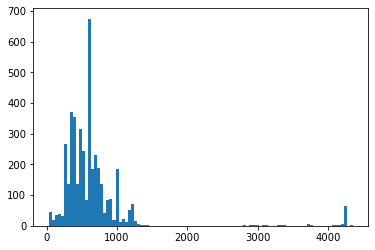

In [7]:
plt.hist(pr_lens, bins=100)

Clearly, all sequences with a length above 2000 should be viewed as outliers. The histogram peaks at around 380 and 551 AAs, and dies down at around 1400 AAs. Then some outliers occur at around 3000-4000. Also, there's a clear drop in sequences occuring below 205 AAs. Which is kind of what we would expect from a biology standpoint. So we'll put two filters at 250 (conservative) and 1500.

In [5]:
to_delete = []
for i, sequence in enumerate(RBPs.protein_seq):
    if (len(sequence) < 250) or (len(sequence) > 1500):
        to_delete.append(i)
        
RBPs = RBPs.drop(to_delete)
RBPs = RBPs.reset_index(drop=True)
RBPalign = np.delete(RBPalign, to_delete, 0)
RBPalign = np.delete(RBPalign, to_delete, 1)
RBPalignN = np.delete(RBPalignN, to_delete, 0)
RBPalignN = np.delete(RBPalignN, to_delete, 1)
RBPalignC = np.delete(RBPalignC, to_delete, 0)
RBPalignC = np.delete(RBPalignC, to_delete, 1)

RBPs.shape
RBPalign.shape

(3933, 3933)

### 4 -  RBP building blocks

In this section, we try to visualize the different building blocks of RBPs we have identified in previous work and look at their occurrence (= counts) across the species (using a heatmap).

*Heatmap without MillardLab RBPs*

In [7]:
# define the paths and RBP building blocks (first all N-term, then C-term, then chaps)
blocks = ['Phage_T7_tail','Tail_spike_N','Prophage_tail','BppU_N','Mtd_N','Head_binding','DUF3751','End_N_terminal', 
           'phage_tail_N','Prophage_tailD1','DUF2163','Phage_fiber_2','phage_RBP_N1','phage_RBP_N4','phage_RBP_N26',
           'phage_RBP_N28','phage_RBP_N34','phage_RBP_N45', 'other_N', 'unknown_N',
           'Lipase_GDSL_2','Pectate_lyase_3','gp37_C','Beta_helix','Gp58','End_beta_propel','End_tail_spike', 
           'End_beta_barrel','PhageP22-tail','Phage_spike_2','gp12-short_mid','Collar', 'phage_RBP_C2', 
           'phage_RBP_C10','phage_RBP_C24','phage_RBP_C43','phage_RBP_C59','phage_RBP_C60','phage_RBP_C62',
            'phage_RBP_C67','phage_RBP_C79','phage_RBP_C97','phage_RBP_C111','phage_RBP_C115','phage_RBP_C120',
            'phage_RBP_C126','phage_RBP_C138','phage_RBP_C143','phage_RBP_C157','phage_RBP_C164','phage_RBP_C175',
            'phage_RBP_C180','phage_RBP_C205','phage_RBP_C217','phage_RBP_C220','phage_RBP_C221','phage_RBP_C223',
            'phage_RBP_C234','phage_RBP_C235','phage_RBP_C237','phage_RBP_C249','phage_RBP_C259','phage_RBP_C267',
            'phage_RBP_C271','phage_RBP_C277','phage_RBP_C281','phage_RBP_C292','phage_RBP_C293','phage_RBP_C296', 
            'phage_RBP_C300','phage_RBP_C301','phage_RBP_C319','phage_RBP_C320','phage_RBP_C321','phage_RBP_C326', 
            'phage_RBP_C331','phage_RBP_C337','phage_RBP_C338','phage_RBP_C340',
           'Peptidase_S74', 'Phage_fiber_C', 'S_tail_recep_bd', 'CBM_4_9', 'DUF1983', 'DUF3672', 'other_C', 'unknown_C']

# initialize dict
map_dict = {'enterococcus_faecium': [0]*len(blocks),'staphylococcus_aureus': [0]*len(blocks), 
               'klebsiella_pneumoniae': [0]*len(blocks), 'acinetobacter_baumannii': [0]*len(blocks),
               'pseudomonas_aeruginosa': [0]*len(blocks), 'enterobacter_cloacae': [0]*len(blocks), 
               'enterobacter_aerogenes': [0]*len(blocks)}

# loop over every species and make dict of counts of every block (incl 'other')
loc_otherN = blocks.index('other_N')
loc_otherC = blocks.index('other_C')
loc_unknownN = blocks.index('unknown_N')
loc_unknownC = blocks.index('unknown_C')
bar = tqdm(total=len(RBPs.sequence), leave=True)
for i, sequence in enumerate(RBPs['sequence']):
    host = RBPs['host'][i]
    domains, scores, biases, ranges = exu.gene_domain_scan(hmm_path, pfam_db, [sequence], threshold=18)
    unknown_N = 0
    unknown_C = 0
    # loop over hits and count the significants in the correct key of the dictionary
    for j, dom in enumerate(domains):
        OM_score = math.floor(math.log(scores[j], 10)) # order of magnitude
        OM_bias = math.floor(math.log(biases[j]+0.00001, 10))
        # add building block domain at correct location
        if (OM_score > OM_bias) and (dom in blocks):
            location = blocks.index(dom)
            if (location <= loc_unknownN):
                unknown_N += 1
                map_dict[host][location] += 1
            elif (location > loc_unknownN) and (scores[j] >= 25): # C-terminals over 25
                unknown_C += 1
                map_dict[host][location] += 1
        # add other_N domain
        elif (OM_score > OM_bias) and (dom not in blocks) and (ranges[j][1] < 200):
            map_dict[host][loc_otherN] += 1
            unknown_N += 1
        # add other_C domain
        elif (OM_score > OM_bias) and (dom not in blocks) and (ranges[j][1] >= 200) and (scores[j] >= 25):
            map_dict[host][loc_otherC] += 1
            unknown_C += 1
    # add counts if no known domain was found
    if unknown_N == 0:
        map_dict[host][loc_unknownN] += 1
    elif unknown_C == 0:
        map_dict[host][loc_unknownC] += 1
    bar.update(1)
bar.close()
    
# convert dict to matrix and normalize to plot as heatmap (rows = species, cols = building blocks)
map_df = pd.DataFrame.from_dict(map_dict)
map_array = np.asarray(map_df).T
map_array_N = map_array[:,:loc_unknownN+1]
map_array_C = map_array[:,loc_unknownN+1:]
print('test dimensions:', map_array.shape[1] == (map_array_N.shape[1]+map_array_C.shape[1]))

# split and normalize N/C separately, then concat again
map_array_N = map_array_N/map_array_N.sum(axis=1, keepdims=1)
map_array_C = map_array_C/map_array_C.sum(axis=1, keepdims=1)
map_array = np.concatenate((map_array_N, map_array_C), axis=1)
map_array.shape

  0%|          | 0/3933 [00:00<?, ?it/s]

test dimensions: True


(7, 87)

In [22]:
# new clusters
pd.DataFrame(map_array_C, columns=blocks[20:])[['phage_RBP_C120', 'phage_RBP_C143', 'phage_RBP_C175', 'phage_RBP_C221', 'phage_RBP_C234', 'phage_RBP_C237', 'phage_RBP_C271', 'phage_RBP_C277']]

,phage_RBP_C120,phage_RBP_C143,phage_RBP_C175,phage_RBP_C221,phage_RBP_C234,phage_RBP_C237,phage_RBP_C271,phage_RBP_C277
0,0.164201,0.16716,0.000000,0.000000,0.023669,0.023669,0.000000,0.000000
1,0.000000,0.00000,0.119203,0.237639,0.000000,0.000000,0.236489,0.119203
2,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


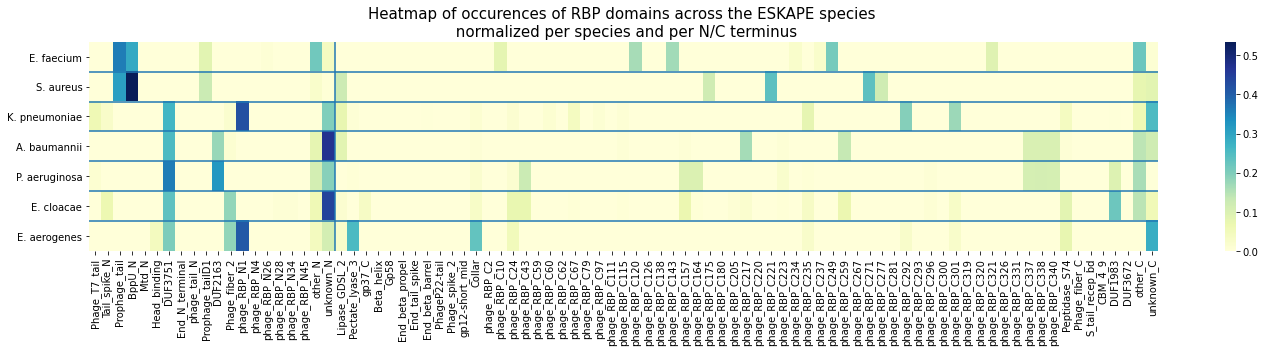

In [10]:
fig, ax = plt.subplots(figsize=(20,5))
xticks = blocks
yticks = ['E. faecium', 'S. aureus', 'K. pneumoniae', 'A. baumannii', 'P. aeruginosa', 'E. cloacae', 'E. aerogenes']
sns.heatmap(map_array, cmap='YlGnBu', xticklabels=xticks, yticklabels=yticks)
ax.hlines([1, 2, 3, 4, 5, 6], *ax.get_xlim())
ax.vlines([loc_unknownN+1], *ax.get_ylim())
ax.set_title('Heatmap of occurences of RBP domains across the ESKAPE species \n normalized per species and per N/C terminus', size=15)
plt.tight_layout()
fig.savefig('/Users/dimi/GoogleDrive/PhD/4_WP2_PWLEARNING/43_RESULTS/RBP_exploration/prophages_domains_heatmap_thr18.png', dpi=400)

*Heatmap with MillardLab RBPs included*

In [16]:
milrbps = pd.read_csv('/Users/Dimi/GoogleDrive/PhD/3_WP1_PHAGEBASE/32_DATA/MillardLab_RBPs.csv', sep='\t')
to_delete = [index for index, name in enumerate(milrbps['ProteinName']) if 'attachment' in name]
milrbps.drop(index=to_delete, inplace=True)
milrbps.reset_index(inplace=True)

In [17]:
mil_df = pd.DataFrame({'phage_nr': [999]*milrbps.shape[0], 'host': milrbps.Host, 'host_accession': milrbps.Accession,
                      'sequence': milrbps.DNASeq, 'protein_seq': milrbps.ProteinSeq})
RBPs = pd.concat([RBPs, mil_df], axis=0, ignore_index=True)

In [18]:
# define the paths and RBP building blocks (first all N-term, then C-term, then chaps)
blocks = ['Phage_T7_tail','Tail_spike_N','Prophage_tail','BppU_N','Mtd_N','Head_binding','DUF3751','End_N_terminal', 
           'phage_tail_N','Prophage_tailD1','DUF2163','Phage_fiber_2','phage_RBP_N1','phage_RBP_N4','phage_RBP_N26',
           'phage_RBP_N28','phage_RBP_N34','phage_RBP_N45', 'other_N', 'unknown_N',
           'Lipase_GDSL_2','Pectate_lyase_3','gp37_C','Beta_helix','Gp58','End_beta_propel','End_tail_spike', 
           'End_beta_barrel','PhageP22-tail','Phage_spike_2','gp12-short_mid','Collar', 'phage_RBP_C2', 
           'phage_RBP_C10','phage_RBP_C24','phage_RBP_C43','phage_RBP_C59','phage_RBP_C60','phage_RBP_C62',
            'phage_RBP_C67','phage_RBP_C79','phage_RBP_C97','phage_RBP_C111','phage_RBP_C115','phage_RBP_C120',
            'phage_RBP_C126','phage_RBP_C138','phage_RBP_C143','phage_RBP_C157','phage_RBP_C164','phage_RBP_C175',
            'phage_RBP_C180','phage_RBP_C205','phage_RBP_C217','phage_RBP_C220','phage_RBP_C221','phage_RBP_C223',
            'phage_RBP_C234','phage_RBP_C235','phage_RBP_C237','phage_RBP_C249','phage_RBP_C259','phage_RBP_C267',
            'phage_RBP_C271','phage_RBP_C277','phage_RBP_C281','phage_RBP_C292','phage_RBP_C293','phage_RBP_C296', 
            'phage_RBP_C300','phage_RBP_C301','phage_RBP_C319','phage_RBP_C320','phage_RBP_C321','phage_RBP_C326', 
            'phage_RBP_C331','phage_RBP_C337','phage_RBP_C338','phage_RBP_C340',
           'Peptidase_S74', 'Phage_fiber_C', 'S_tail_recep_bd', 'CBM_4_9', 'DUF1983', 'DUF3672', 'other_C', 'unknown_C']

# initialize dict
map_dict = {'enterococcus_faecium': [0]*len(blocks),'staphylococcus_aureus': [0]*len(blocks), 
               'klebsiella_pneumoniae': [0]*len(blocks), 'acinetobacter_baumannii': [0]*len(blocks),
               'pseudomonas_aeruginosa': [0]*len(blocks), 'enterobacter_cloacae': [0]*len(blocks), 
               'enterobacter_aerogenes': [0]*len(blocks), 'MillardLab_RBPs': [0]*len(blocks)}

# loop over every species and make dict of counts of every block (incl 'other')
loc_otherN = blocks.index('other_N')
loc_otherC = blocks.index('other_C')
loc_unknownN = blocks.index('unknown_N')
loc_unknownC = blocks.index('unknown_C')
bar = tqdm(total=len(RBPs.sequence), leave=True)
for i, sequence in enumerate(RBPs['sequence']):
    host = RBPs['host'][i]
    domains, scores, biases, ranges = exu.gene_domain_scan(hmm_path, pfam_db, [sequence], threshold=18)
    unknown_N = 0
    unknown_C = 0
    # loop over hits and count the significants in the correct key of the dictionary
    for j, dom in enumerate(domains):
        # order of magnitude
        OM_score = math.floor(math.log(scores[j], 10))
        OM_bias = math.floor(math.log(biases[j]+0.00001, 10))
        # add building block domain at correct location
        if (OM_score > OM_bias) and (dom in blocks):
            location = blocks.index(dom)
            if host in map_dict.keys():
                if location <= loc_unknownN:
                    map_dict[host][location] += 1
                    unknown_N += 1
                elif (location > loc_unknownN) and (scores[j] >= 25):
                    map_dict[host][location] += 1
                    unknown_C += 1
            else:
                if location <= loc_unknownN:
                    map_dict['MillardLab_RBPs'][location] += 1
                    unknown_N += 1
                elif (location > loc_unknownN) and (scores[j] >= 25):
                    map_dict['MillardLab_RBPs'][location] += 1
                    unknown_C += 1
        # add other_N domain
        elif (OM_score > OM_bias) and (dom not in blocks) and (ranges[j][1] < 200):
            if host in map_dict.keys():
                map_dict[host][loc_otherN] += 1
            else:
                map_dict['MillardLab_RBPs'][loc_otherN] += 1
            unknown_N += 1
        # add other_C domain
        elif (OM_score > OM_bias) and (dom not in blocks) and (ranges[j][1] >= 200) and (scores[j] >= 25):
            if host in map_dict.keys():
                map_dict[host][loc_otherC] += 1
            else:
                map_dict['MillardLab_RBPs'][loc_otherC] += 1
            unknown_C += 1
    # add counts if no known domain was found
    if unknown_N == 0:
        if host in map_dict.keys():
            map_dict[host][loc_unknownN] += 1
        else:
            map_dict['MillardLab_RBPs'][loc_unknownN] += 1
    elif unknown_C == 0:
        if host in map_dict.keys():
            map_dict[host][loc_unknownC] += 1
        else:
            map_dict['MillardLab_RBPs'][loc_unknownC] += 1
    bar.update(1)
bar.close()
    
# convert dict to matrix and normalize to plot as heatmap (rows = species, cols = building blocks)
map_df = pd.DataFrame.from_dict(map_dict)
map_array = np.asarray(map_df).T
map_array_N = map_array[:,:loc_unknownN+1]
map_array_C = map_array[:,loc_unknownN+1:]
print('test dimensions:', map_array.shape[1] == (map_array_N.shape[1]+map_array_C.shape[1]))

# split and normalize N/C separately, then concat again
map_array_N = map_array_N/map_array_N.sum(axis=1, keepdims=1)
map_array_C = map_array_C/map_array_C.sum(axis=1, keepdims=1)
map_array = np.concatenate((map_array_N, map_array_C), axis=1)
map_array.shape

  0%|          | 0/8899 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.7/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


test dimensions: True


(8, 87)

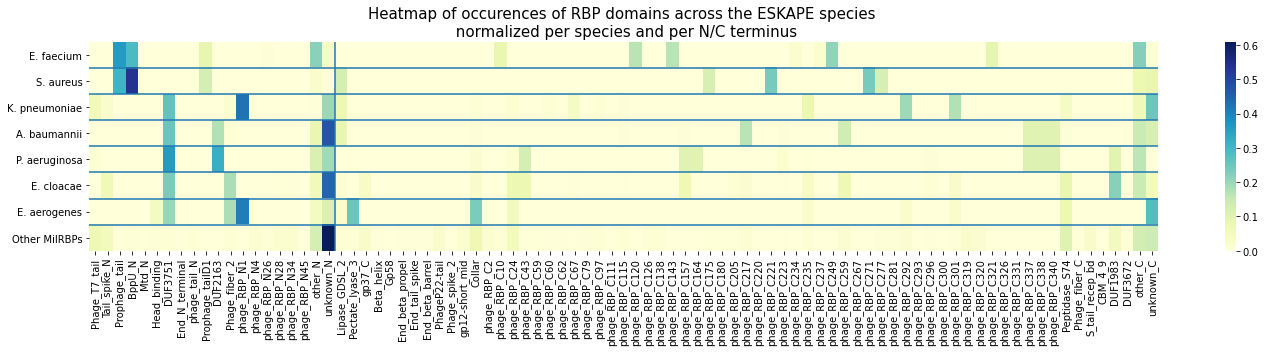

In [19]:
fig, ax = plt.subplots(figsize=(20,5))
xticks = blocks
yticks = ['E. faecium', 'S. aureus', 'K. pneumoniae', 'A. baumannii', 'P. aeruginosa', 'E. cloacae', 'E. aerogenes', 'Other MilRBPs']
sns.heatmap(map_array, cmap='YlGnBu', xticklabels=xticks, yticklabels=yticks)
ax.hlines([1, 2, 3, 4, 5, 6, 7], *ax.get_xlim())
ax.vlines([20], *ax.get_ylim())
ax.set_title('Heatmap of occurences of RBP domains across the ESKAPE species \n normalized per species and per N/C terminus', size=15)
plt.tight_layout()
fig.savefig('/Users/dimi/GoogleDrive/PhD/4_WP2_PWLEARNING/43_RESULTS/RBP_exploration/allRBPs_domains_heatmap.png', dpi=400)

The heatmap of normalized count (P(domain ¡ host)) looks somewhat better than when we display absolute counts. In addition, we have normalized all of the building blocks of the N-terminus separately from the one of the C-terminus. This allows us to more easily appreciate how the building blocks at the N-terminus are distributed and those at the C-terminus (because these are two separate distributions of course! = mosaicism). 

Looking at the N-terminus, the first thing we notice is two groups (E. faecium + S. aureus) that are characterized by the proportionally equal occurence of Prophage_tail and BppU_N; and the other species that are characterized by the occurence of DUF3751 together with DUF2163 or Phage_fiber_2. Overall, not many of the N-terminal blocks are 'other_N', meaning protein domains that occur but that we haven't (manually) identified to be related to RBPs. In addition, we see some unknown blocks, particularly present at the C-terminus for E. faecium and S. aureus. A. baumannii also exhibits some unknown blocks but here at the N-terminus.

Looking at the C-terminus, we see that E. faecium mostly has other C-terminal domains (which we also noticed on the first network-style visualization we made), which in a sense is weird because this should have been 'dealt with' at the stage of the RBP detection: we have attempted to discover unknown N/C termini and clustering them to construct new HMMs. If E. faecium sequences weren't included in these new HMMs, it is because they appeared in clusters that were too small (less than 5 entries per cluster). Indeed, in of the 347 C-terminal clusters that were identified, only 47 (=13.5%) of them contained more than 5 sequences. S. aureus looks very binary at the C-terminus: either Lipase_GDSL_2 or some other domain(s). K. pneumoniae and P. aeruginosa and mostly E. aerogenes as well seem pretty much equally distributed (indeed, we observed before that many of the in-house constructed HMMs match K. pneumoniae and P. aeruginosa sequences). A. baumannii also matches some of these constructed HMMs but in a much more sparse way (most matches with phage_RBP_C296, some with phage_RBP_C220 and phage_RBP_C10).

UPDATE 15/04

The picture at the C-terminus improved for E. faecium, but for S. aureus we still have most C-terminal ends unknown. This means that C-terminal ends that do not share a known domain are too dissimilar to be taken up into HMMs (cfr. cluster of >=5 members). But does this make sense? Above, we do see the histograms of the C-terminal ends, in which there are sequences that share 70+% identity. So for these not to be involved in clusters, they must have a known C-terminal end.

UPDATE 16/04

Something we also notice is that for K. pneumoniae, A. baumannii and E. cloacae, most of the N-terminal blocks are also unknown! Would the reason for this be similar to the S. aureus C-terminal unknowns? In general, over all species, we see that our constructed N-terminal HMMs have not picked up any of the sequences in the set... Not finding many hits for the species that have a lot of other KNOWN N-terminal blocks is expected (e.g. E. faecium and S. aureus and even P. aeruginosa). But the ones with the majority of unknown blocks is weird. Because these are the ones that you would expect to be in the HMM construction, and thus those that you would want to find. Same for S. aureus at the C-terminus.

The size of the clusters does not seem to be of influence, because the big N_28 cluster has 79 sequences in it but doesn't find anything here! Looking in detail at the HMM hits of N_28, we find 13 hits in the database, but all of them with a score < 25 (don't pass the threshold). Most of them are in the range of 12-14 scores. And still, it is remarkable that from a profile of 79 sequences (those same sequences), that only 13 of them are picked up afterwards.

One potential explanation for the N-terminals: because we see that at the C-terminus, this problem doesn't occur, it might have to do with the length of the profiles. More specifically, shorter sequences lead to lower scores (while still 'significant' hits)

CONCLUSIONS:
- The heatmap is not a complete picture, as we filter some of the newly constructed HMMs out of precaution (suspicious annotations).
- While it is true that most clusters have only one member, and thus we don't see them in the HMM construction, this only represents 16.6% of the sequences in all of the clusters. Meaning: there are some cluster that have a substantial amount of sequences in them (50+). From a sequence perspective, we still include +75% of the C-terminal ends in the HMMs.
- The S. aureus sequences are thus not all unique or much more diverse than the other species. It's because they were in cluster C_221, which got filtered.
- The known C-terminal building blocks don't occur very often, but this has been the case throughout all the iterations, this is not new.
- The strange last thing, is the newly constructed N-terminals. This partly has to do with cluster N_1 that got filtered, but we've also noticed strange behaviour for e.g. N_28, which has 79 members but afterwards only finds 13 hits that are all filtered under the score threshold... **remaining question: why does a profile built with unknown sequences at first not find those after it is built?** Versus: cluster 1 only containing 7 sequences and then detecting a loooot of new hits?!
- We've trained HMMs on MillardLab RBPs as well, explains why some models have no hits whatsoever!

UPDATE 30/04

After adding the new HMMs to Pfam extended and appropriately renaming these HMMs, we see a result that we expect. The unknowns for S. aureus are gone, and spread out accross the HMMs that we hadn't included before. Now we do notice 'many' unknown hits at the N-terminus, for E. cloacae and A. baumannii, but this is misleading as it is shown in a heatmap! Previously, the largest values on the heatmap were 0.8, while now this is only 0.5. So colors can't be compared to previously constructed heatmaps. In general, we wouls expect a little more hits as we've lowered the threshold for N-terminal HMMs from 25 to 18. But ofcourse, we can not make hard conclusions based on the heatmap, because it only shows frequencies, not absolute numbers. 

The fact that we do see quite a lot of unknowns (especially for A. baumannii and E. cloacae), we can pose the question whether more novel HMMs could additionally be constructed for the N-terminus (because now, we have included all of the HMMs that we have already constructed).

UPDATE 03/05

What is a good precision here? A good precision would be if we only include a sequence if:

1. the sequence has at least one known Pfam RBP-related domain (not custom built by us) at either N- or C-terminus, in combination with either a custom built HMM or an other domain or an unknown.
2. the sequence has a combination of custom built HMMs, both of which ALSO occur in combination with known Pfam RBP domains.

Hypothesis: in HMMs built with many sequences, some of the 'signal' of a subpart of the sequences may get lost (signal-to-noise ratio) due to the presence of the other sequences, which leads to insignificant hits.

We see a lot of hits in cluster C_221, but this is one that we have discarded based on suspicious annotation! The same might be true for cluster N_1, which was also discarded but often had hits related to Klebsiella and Acinetobacter...

Text(0, 0.5, 'number of occurences')

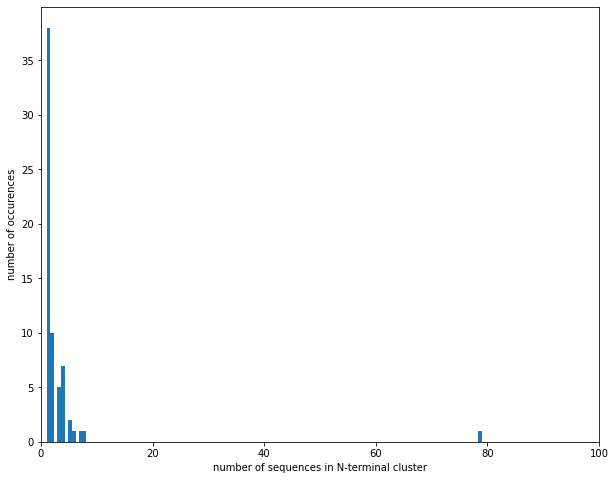

In [5]:
# histogram of number of sequences in the clusters
dom_path = '/Users/Dimi/GoogleDrive/PhD/3_WP1_PHAGEBASE/32_DATA/RBP_detection/clusters' 
clusters_unknown_C = open(dom_path+'/'+ 'unknown_N_termini.clstr')
cluster_count = 0
cluster_sizes = []
for line in clusters_unknown_C.readlines():
    # new cluster
    if line[0] == '>':
        cluster_sizes.append(cluster_count)
        cluster_count = 0
    # in a cluster -> count sequence
    else:
        cluster_count += 1
cluster_sizes.pop(0) # delete first artifact

# make histogram
fig, ax = plt.subplots(figsize=(10,8))
plt.hist(cluster_sizes, bins=120)
plt.xlim(0, 100)
plt.xlabel('number of sequences in N-terminal cluster')
plt.ylabel('number of occurences')
#plt.savefig('/Users/dimi/GoogleDrive/PhD/4_WP2_PWLEARNING/43_RESULTS/RBP_exploration/cluster40_size_histogram.png', dpi=400)

In [4]:
# proportion of sequences that reside in a singular cluster (size 1)
(cluster_sizes.count(1)+cluster_sizes.count(2)+cluster_sizes.count(3)+cluster_sizes.count(4))/ sum(cluster_sizes)

0.2843601895734597

In [ ]:
# see how many E faecium and S aureus sequences in the different clusters
# {cluster_size: species_sequences}
#indices = [index for index, sequence in enumerate(genebase.sequence) if cluster_sequence in str(Seq(sequence).translate()[:-1])]
genebase = pd.read_csv('/Users/Dimi/GoogleDrive/PhD/3_WP1_PHAGEBASE/32_DATA/PhageGeneBase.csv')
entero_indices = genebase.host == 'enterococcus_faecium'
staph_indices = genebase.host == 'staphylococcus_aureus'
enteros = genebase.sequence[entero_indices]
staphs = genebase.sequence[staph_indices]

# get the sequences
input_file = dom_path+'/'+ 'unknown_C_cutsequences.fasta'
sequence_list = []
for record in SeqIO.parse(input_file, 'fasta'): # get sequences in a list
    sequence_list.append(str(record.seq))
    
clusters_unknown_C = open(dom_path+'/'+ 'unknown_C_termini.clstr')
for line in clusters_unknown_C.readlines():
    if line[0] == '>':
        # finish old cluster if not the first one
        if (cluster_iter > 0):
            staph_counts = sum([1 for ])
            
            
            
            fasta = open(dom_path+'/'+'unknown_C_termini_cluster_'+str(cluster_iter)+'.fasta', 'w')
            for i, seq in enumerate(cluster_sequences):
                index = cluster_indices[i]
                fasta.write('>sequence'+index+'\n'+seq+'\n')
            fasta.close()
        # initiate new cluster
        cluster_sequences = []
        cluster_indices = []
        cluster_iter += 1
    # in a cluster
    else:
        current_index = re.search('>sequence_[0-9]+', line).group(0).split('sequence_')[1]
        current_sequence = sequence_list[int(current_index)]
        cluster_indices.append(current_index)
        cluster_sequences.append(current_sequence)

The heatmap is interesting, and shows us how different building blocks occur across the species. But it doesn't show us how different combinations of building blocks occur, from which we could infer:
1. how combinations differ accross species
2. which (predicted) HGT events have occurred

This is why the next section focuses on constructing bipartite graphs and/or chord diagrams that illustrate the occurences of the building blocks as well as which combinations of them occur (per species).

### 5 - RBP cluster graph & building blocks

For simplicity, we concat the chaperone domains with the binding domains (we're interested in HGTs between N- and C-terminus). High scoring interactions linked to nodes of high degree, can indicate particularly important interactions in the network. Can we identify differences in 'importance interactions' (= important domain combos here), that differ among the species?!

RERUN RBP set first to exclude MillardLab RBPs!

In [ ]:
species = ['enterococcus_faecium', 'staphylococcus_aureus', 'klebsiella_pneumoniae', 'acinetobacter_baumannii', 
          'pseudomonas_aeruginosa', 'enterobacter_cloacae', 'enterobacter_aerogenes']
for sp in species:
    indices = RBPs.host == sp
    sequences_sp = RBPs.sequence[indices]
    exu.domain_cluster_graph(hmm_path, pfam_db, sequences_sp, filename='/Users/Dimi/Desktop/domains_circos_'+sp+'.png')

Now the question is: can we identify combinations that are unique to some species or that occur more often in some species versus others?

As a reference, the following clusters were initially filtered: N_1, C_120, C_143, C_175, C_221, C_234, C_237, C_271, C_277. These are the clusters we will pay extra attention to. We should also be wary of unknown-unknown combinations and other-unknown or unknown-other combinations.

##### E. faecium
At first glance, the circos graph for E. faecium appears dense. Many different combinations are identified. At the N-terminus, most combinations are with Prophage_tail, BppU_N and other_N. At the side of the C-terminus, we notice a lot of phage_RBP_C143, phage_RBP_C249, phage_RBP_C321 and other_C. The combinations that occur most frequently are (Prophage_tail + phage_RBP_C249), (BppU_N + phage_RBP_C321), (Prophage_tail + other_C), (other_N + phage_RBP_C143) and (other_N + phage_RBP_C120). We also notice very few unknown_C, which is a good thing, but quite a few other_C, which hints at the possibility of adding more known Pfam domains to the curated RBP list. We also notice some (other_N + other_C) combinations. We do not however notice any unknown+unknown, other+unknown or unknown+other combinations, which is good. Additionally, looking at this circos graph, none of the later added clusters look suspicious. The only sequences we could filter here are the (other_N + other_C) combinations.

##### S. aureus
For S. aureus, the first glance of the graph looks quite similar to E. faecium. Here, the one N-terminal building block that is present most often is BppU_N, followed by Prophage_tailD1 and Prophage_tail. At the C-terminus, we see a lot of C221, C271 and C277; in addition to other_C and unknown_C. Interestingly, the three custom built HMMs are all mostly linked to BppU_N. Some sequences seem to have a (unknown_N + other_C) combination, which might seem at first odd as to how it got in the dataset in the first place. But this could actually be a (unknown_N + Lipase_GDSL_2 + other_C) combination, we cannot see those threefold combinations from the circos graphs. Same with a (other_N + unknown_C) combination that could also be a (Prophage_tailD1 + other_N + unknown_C) combination. This is something we can account for in the final filtering below.

##### K. pneumoniae
Here we directly notice the many unknown_N occurences, which was already obvious from the heatmap. To put this into perspective, about 50% of the sequences have an unknown_N block. Most of these unknown_N are linked to C235, which itself is only seldom linked with DUF3751. This could be a block that we filter from the final selection. One other thing we notice is that N1 is mostly linked with unknown_C and other_C and only sometimes linked with Lipase_GDSL_2. Instead of completely discarding those sequences, we can also opt to discard the combinations that we think are dubious (N1 + unknown_C).

##### A. baumannii
Here, DUF3751, DUF2163 and unknown_N are the most occurring at the N-terminus. Two suspicious combinations we see are (unknown_N + **phage_RBP_C217**) and (unknown_N + **phage_RBP_C259**). Both C-terminal HMMs are not related to any other combination! The question now is, do we delete those? As they were not denoted as being suspicious by BLAST results.

##### P. aeruginosa
For P. aeruginosa we immediately notice the DUF3751 and DUF2163 that occur most often, followed by the unknown_N domain. We also see that these are combined with a variety of C-terminal building blocks, mostly custom built ones. This shows a nice example of HGT, but at the same time, we can notice that the combinations with DUF3751 are mostly distinct from the combinations with DUF2163 (groups of phages targeting other strains?). We also notice very few unknown_C, which is a sign that are constructed HMMs capture the C-terminal blocks very well (but in contrast, most of the C-terminal Pfam domains rarely occur).

##### E. cloacae
This is the second species for which we notice many unknown_N, followed by Phage_fiber_2 and DUF3751. One particular suspicious combo that we notice is (unknown_N + C67), as the **C67** does not occur in combination with any other N-terminal block. Same for **C205, C217, C223 and C259**. Of note, both C217 and C223 are connected to DUF3751 for P. aeruginosa.

##### E. aerogenes
Here, DUF3751 and N1 seem to be most occurring at the N-terminus, and three combinations that occur most often are (DUF3751 + Collar), (Phage_fiber_2 + Collar) and (N1 + Pectate_lyase_3). We do not notice any particularly suspicious combination.